In [3]:
!pip install git+https://github.com/rtqichen/torchdiffeq.git

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-trkjauox
  Running command git clone -q https://github.com/rtqichen/torchdiffeq.git /tmp/pip-req-build-trkjauox
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25885 sha256=6d4d542f93062ac94322a77ba1e41b75c20cf45457d317ec18dd8de21fe509f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-c9d12c2a/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq


In [4]:
project_dir = "odenet"
import sys
if True: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/"+project_dir
    sys.path.append(root)
else: # Local
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import torch
import torchvision
from matplotlib import pylab as plt
import torchdiffeq
import copy

In [93]:
import models
import odenet
import refine_train
import importlib
importlib.reload(refine_train)
importlib.reload(models)
importlib.reload(odenet)

<module 'odenet' from '/Users/afq/Google Drive/Colab Notebooks/odenet/odenet.py'>

# Fashion MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,),
                                                 (0.5,)),
            ])
refset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=None)
trainset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## We need a few baselines

In [ ]:
class MyClassifier(torch.nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(784,784),
            torch.nn.ReLU(),
            torch.nn.Linear(784,784),
            torch.nn.ReLU(),
            torch.nn.Linear(784,10),
        )
    def foward(self,x):
        return self.net(x)

# RefineNet

The ODE needs to be cut up when the information decreases.

In [87]:
class MyResNet(torch.nn.Module):
    def __init__(self):
        super(MyResNet,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,1),
            ODEBlock(ConvODE(16,16)),
            torch.nn.MaxPool2d(3),
            ODEBlock(ConvODE(16,16)),
            torch.nn.MaxPool2d(3),
            torch.nn.Flatten(),
            torch.nn.Linear(16*3*3,10),
        )
    def forward(self,x):
        return self.net(x)
    def refine(self):
        new = copy.deepcopy(self)
        for i in range(len(self.net)):
            new.net[i] = refine(self.net[i])
        return new

class PureRefineNet(torch.nn.Module):
    def __init__(self, ode_width=4, inner_width=8):
        super(PureRefineNet,self).__init__()
        self.net = torch.nn.Sequential(
            odenet.ODEBlock(
                odenet.ShallowConv2DODE(1,ode_width,inner_width,
                                        act=torch.nn.functional.leaky_relu)),
            torch.nn.AdaptiveAvgPool2d((3,3)),
            torch.nn.Flatten(),
            torch.nn.Linear(ode_width*3*3,10),
        )
    def forward(self,x):
        y = models.channel_squish(x,2)
        h = self.net(y)
        return h
    def refine(self):
        new = copy.deepcopy(self)
        for i in range(len(self.net)):
            new.net[i] = odenet.refine(self.net[i])
        return new

In [88]:
model = PureRefineNet()

In [69]:
losses = refine_train.train_for_epochs(model, trainloader, torch.nn.CrossEntropyLoss(), 1)

torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([6

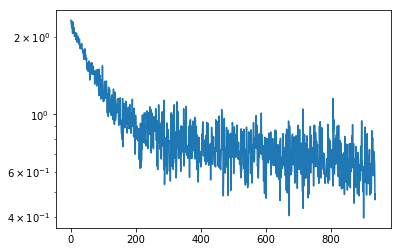

In [70]:
plt.semilogy(losses)

In [94]:
model = PureRefineNet()

In [103]:
model_list, losses, refine_steps = refine_train.train_adapt(model, trainloader, torch.nn.CrossEntropyLoss(), 1, 5)

Starting with  958 with lr =  0.1
Adapting to  1546 with lr =  0.1
Adapting to  2722 with lr =  0.01
Adapting to  5074 with lr =  0.01
Adapting to  9778 with lr =  0.001


([PureRefineNet(
    (net): Sequential(
      (0): ODEBlock(
        (net): ShallowConv2DODE(
          (L1): Conv2DODE()
          (L2): Conv2DODE()
        )
      )
      (1): AdaptiveAvgPool2d(output_size=(3, 3))
      (2): Flatten()
      (3): Linear(in_features=36, out_features=10, bias=True)
    )
  ), PureRefineNet(
    (net): Sequential(
      (0): ODEBlock(
        (net): ShallowConv2DODE(
          (L1): Conv2DODE()
          (L2): Conv2DODE()
        )
      )
      (1): AdaptiveAvgPool2d(output_size=(3, 3))
      (2): Flatten()
      (3): Linear(in_features=36, out_features=10, bias=True)
    )
  ), PureRefineNet(
    (net): Sequential(
      (0): ODEBlock(
        (net): ShallowConv2DODE(
          (L1): Conv2DODE()
          (L2): Conv2DODE()
        )
      )
      (1): AdaptiveAvgPool2d(output_size=(3, 3))
      (2): Flatten()
      (3): Linear(in_features=36, out_features=10, bias=True)
    )
  ), PureRefineNet(
    (net): Sequential(
      (0): ODEBlock(
        (net

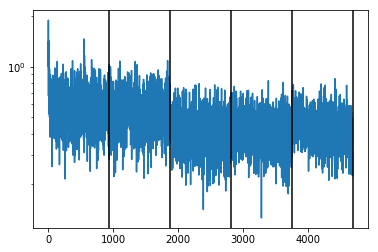

In [108]:
plt.semilogy(losses)
plt.semilogy([x for x,y in test_losses], [y for x,y in test_losses])
for r in refine_steps:
    plt.axvline(r,color='k')

In [109]:
def plot_accuracy(model):
    imgs,labels = next(iter(trainloader))
    res = torch.nn.Softmax(dim=-1)(model(imgs[:10,:,:,:]))
    size = len(res)
    plt.figure(figsize=(10,10))
    for i,(pred,img,label) in enumerate(zip(res,imgs,labels)):
        plt.subplot(size//2+1,4,1+2*i)
        plt.imshow(img[0,:,:].detach().numpy(),cmap='Greys')
        plt.subplot(size//2+1,4,2+2*i)
        plt.bar(range(10),[1 if y==label else 0 for y in range(10)])
        plt.bar(range(10),pred.detach().numpy())
    plt.show()

torch.Size([10, 10])


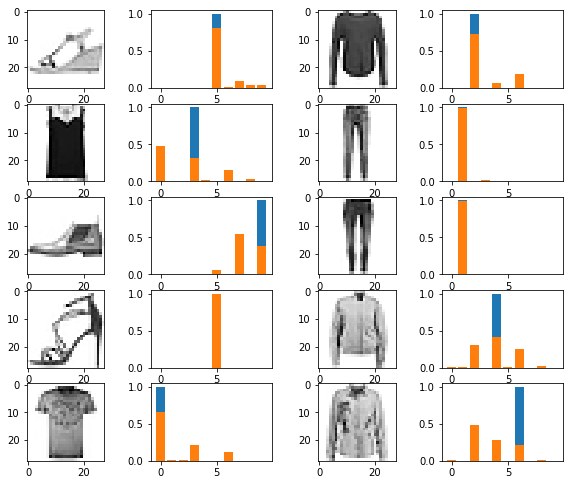

In [73]:
plot_accuracy(model)

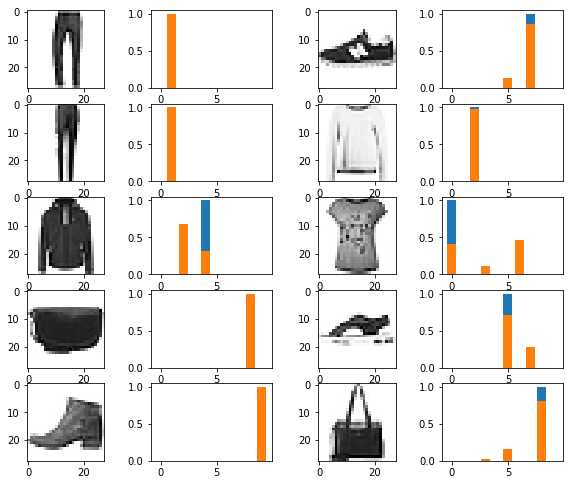

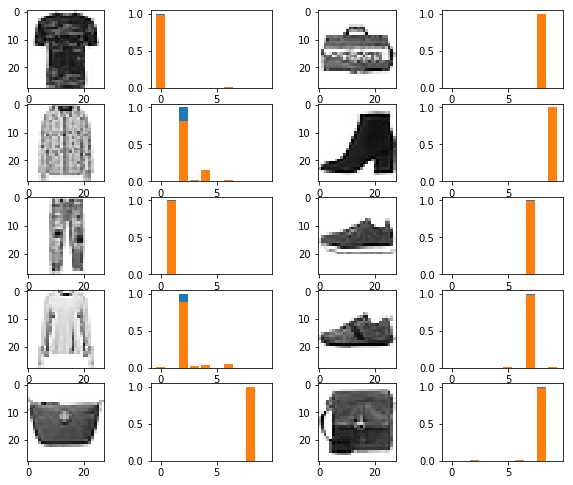

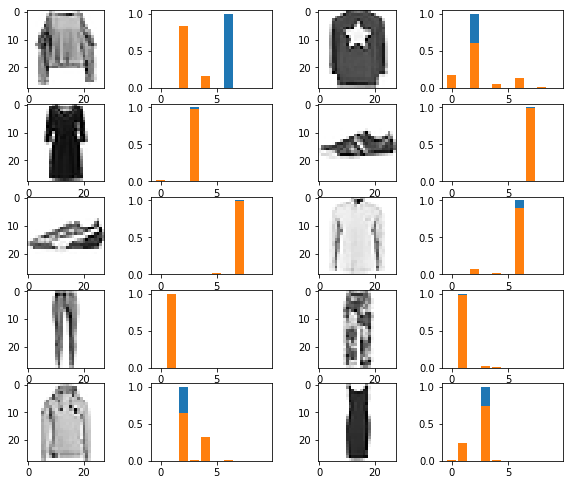

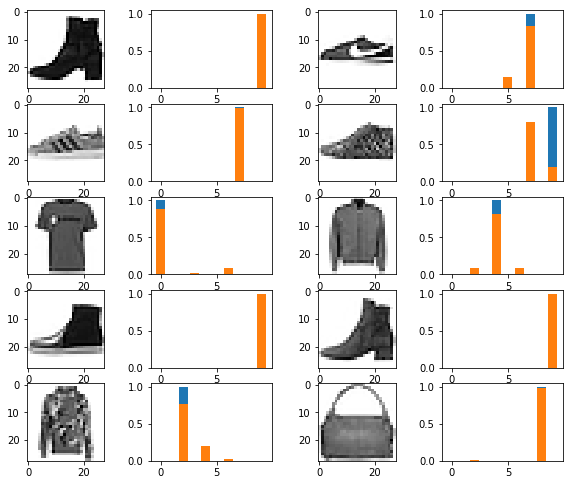

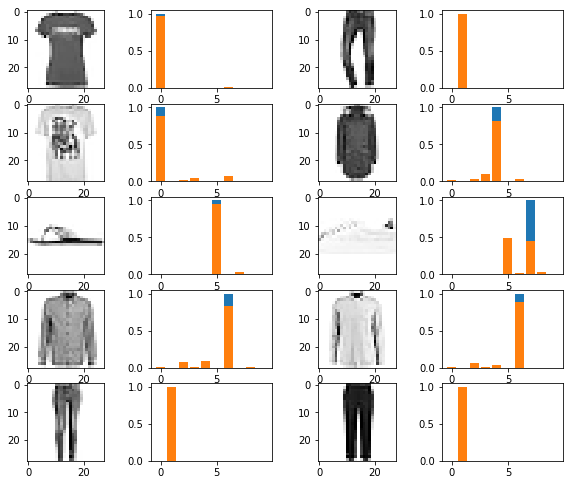

In [110]:
for m in model_list:
    plot_accuracy(m)

In [ ]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']